In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import datetime
from pathlib import Path

import jax
# from jax import vmap, jit
import jax.numpy as jnp
import jax.random as random

jax.config.update("jax_enable_x64", True)
# numpyro.set_host_device_count(2)

from maf_gp import model_n_hv, run_inference_hv

In [2]:
# get data
data_path_h = Path("./data_extension_h")
data_path_v = Path("./data_extension_v")
# data to use
angles = [45, 90, 135] 

# experimental data
input_xy_exp = []
data_exp_h = []
for file_load_angle, file_ext in zip( sorted(data_path_h.glob("input_load_angle_exp_*")),
                sorted(data_path_h.glob("data_extension_exp_*")) ):
    load_angle = np.loadtxt(file_load_angle, delimiter=",")
    if (np.abs(np.rad2deg(load_angle[0,1]) - np.array(angles)) < 1e-6).any():
        input_xy_exp.append(load_angle)
        data_exp_h.append(np.loadtxt(file_ext, delimiter=",").mean(axis=1))

data_exp_v = []
for file_load_angle, file_ext in zip( sorted(data_path_v.glob("input_load_angle_exp_*")),
                sorted(data_path_v.glob("data_extension_exp_*")) ):
    load_angle = np.loadtxt(file_load_angle, delimiter=",")
    if (np.abs(np.rad2deg(load_angle[0,1]) - np.array(angles)) < 1e-6).any():
        # input_xy_exp.append(load_angle)
        data_exp_v.append(np.loadtxt(file_ext, delimiter=",").mean(axis=1))
    
# simulation data
input_xy_sim = jnp.array(np.loadtxt(data_path_h / "input_load_angle_sim.txt", delimiter=","))
input_theta_sim = jnp.array(np.loadtxt(data_path_h / "input_theta_sim.txt", delimiter=","))
data_sim_h = jnp.array(np.loadtxt(data_path_h / "data_extension_sim.txt", delimiter=",")).mean(axis=1)

data_sim_v = jnp.array(np.loadtxt(data_path_v / "data_extension_sim.txt", delimiter=",")).mean(axis=1)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
# numpyro.render_model(model, model_args=(input_xy_exp, input_xy_sim, input_theta_sim, data_exp, data_sim))
# data_exp_h

In [4]:
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(12345))
# whether to add bias_E1
add_bias_E1 = False 
# whether to add bias_alpha
add_bias_alpha = False
# direction = data_path.stem[-1]
mcmc = run_inference_hv(model_n_hv, rng_key, input_xy_exp, input_xy_sim, input_theta_sim, data_exp_h, data_exp_v, data_sim_h, data_sim_v, 
                     add_bias_E1=add_bias_E1, add_bias_alpha=add_bias_alpha)
samples = mcmc.get_samples()

C:\Users\Sinan\Documents\CerTest\MAF_PY\maf_gp.py:508: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|███████████████████████████| 6000/6000 [14:13<00:00,  7.03it/s, 15 steps of size 3.80e-01. acc. prob=0.92]



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             E_1_n     -2.53      1.13     -2.52     -4.51     -0.80   4654.28      1.00
             E_2_n     -0.04      1.00     -0.03     -1.62      1.68   4640.71      1.00
            G_12_n     -0.26      1.00     -0.26     -1.88      1.36   4841.07      1.00
       lambda_E1_n      0.78      0.34      0.78      0.21      1.32   4866.00      1.00
       lambda_E2_n      3.08      0.68      3.07      1.96      4.19   4806.05      1.00
      lambda_G12_n      2.83      0.65      2.83      1.70      3.82   4560.02      1.00
        lambda_P_n      2.53      0.29      2.54      2.03      2.98   4693.58      1.00
    lambda_alpha_n      0.72      0.17      0.72      0.44      1.00   4675.24      1.00
      lambda_v12_n      1.91      0.74      1.89      0.66      3.07   4497.97      1.00
      lambda_v23_n     -0.06      0.47     -0.09     -0.85      0.67   4765.79      1.00
     mu_emulator_n  

In [5]:
# save posterior samples
date_str = datetime.datetime.now().strftime("_%Y_%m_%d_%H_%M_%S_")
file_path = Path("results_mcmc")
file_path.mkdir(exist_ok=True)
if len(angles) == 3:
    suffix = "hv"
else:
    suffix = "hv"
    for i in angles:
        suffix = suffix + '_' + str(i)

if not add_bias_E1 and not add_bias_alpha:
    prefix = "no_bias_"
else:
    prefix = "bias_"

if add_bias_E1:
    prefix = prefix + "E1_"
if add_bias_alpha:
    prefix = prefix + "alpha_"

file_path =  file_path.joinpath(prefix + suffix + date_str + "MAF_linear.h5")
    
f = h5py.File(file_path, 'w')
for key in samples.keys():
    f.create_dataset(key, data=samples[key])
f.close()

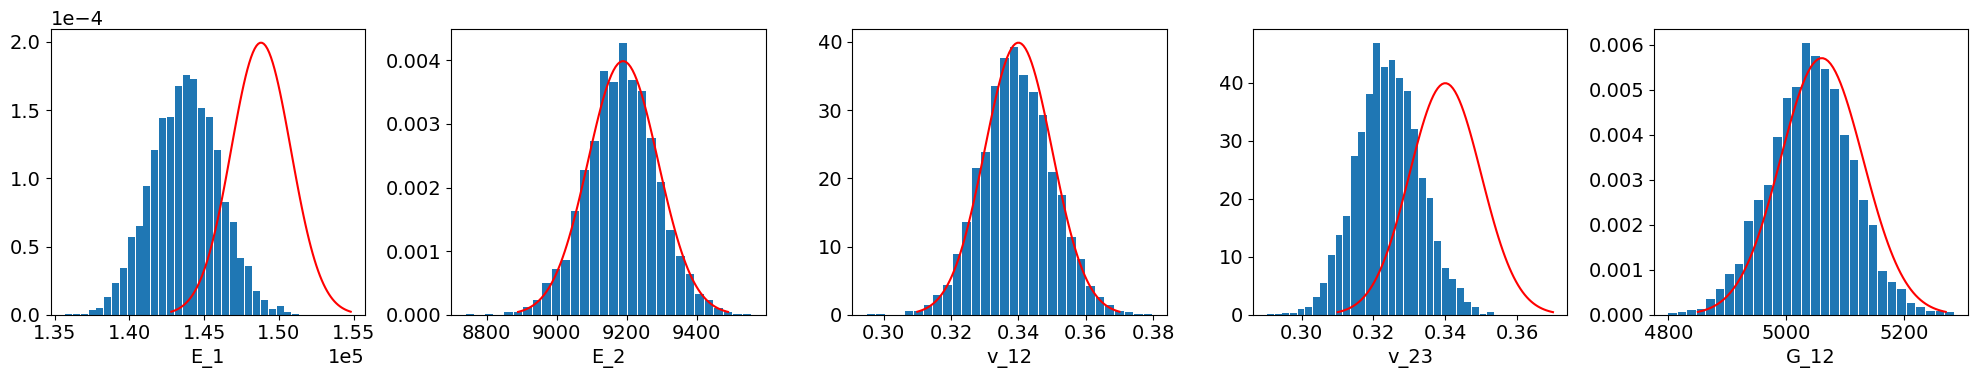

In [16]:
# plot prior-posterior distributions
import numpyro.distributions as dist
matplotlib.rcParams["axes.formatter.limits"] = [-4,4]
matplotlib.rcParams["font.size"] = 14
prior_dist = [] 
prior_dist.append(dist.Normal(148800, 2000))
prior_dist.append(dist.Normal(9190, 100))
prior_dist.append(dist.Normal(0.34, 0.01))
prior_dist.append(dist.Normal(0.34, 0.01))
prior_dist.append(dist.Normal(5060, 70))

keys = ['E_1', 'E_2', 'v_12', 'v_23', 'G_12']
fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(20,4))
dic = {}
for i in range(len(keys)):
    x_prior = jnp.linspace(prior_dist[i].mean - 3 * prior_dist[i].variance**(0.5), prior_dist[i].mean + 3 * prior_dist[i].variance**(0.5), 100)
    ax[i].plot(x_prior, jnp.exp(prior_dist[i].log_prob(x_prior)), 'r')  
    ax[i].hist(samples[keys[i]], bins=30, rwidth=0.9, density=True)
    ax[i].set_xlabel(keys[i])
    dic[keys[i]] = samples[keys[i]]
fig.tight_layout()
